# Pre-content: Planning

- get binder working
- clean-up pass
- share w Friedrich, request feedback
- widgets are nice but cite bokeh (or?) for interactivity, cf Jake also
- investigate: app mode? or (per Hunter) accordion windows? jupyterlab?
- finish compressing data and refactor code to operate on compressed, not de novo
  - done: Extracting 5 months of time series surface ChlorA from MODIS at 0.1 deg 21 x 21 centered on OSB
  - not done: consolidate Aug 21 shallow profiler datasets into minimal size; and load those 
  - not done: argo data set up
- short .wav clip in place in intro w link to megaptera
- migrate gallery to cormorack org; work in a dev branch

- [ed materials](https://github.com/ooi-data-review/2018-data-workshops/blob/master/physics/examples/Example%2002%20-%20Using%20the%20OOI%20API%20with%20Python.ipynb)
- [Keenan's work](https://github.com/cormorack/notebooks/blob/master/dev_notebooks/keenan/DO%20vs.%20Temperature%20vs.%20Nitrate.ipynb)
- teaching 
  - Janel
  - Susan (OCNG-200)
  - method to compare separate observation streams with independent clocks
- glodap
  - final check on color schemes
- map += CA and argo
- RCO comparative: MODIS, argo, glodap, gliders, surface (K/W), tethered, casts: Emph chlor
  - particularly MODIS chlor continuation downwards to 200m chart 'what happens below'



# Ocean Science

<img src="./humpback.png" style="float: left;" alt="drawing" width="500"/>
<div style="clear: left"><BR>

The ocean is full of water, true, but also dissolved oxygen gas, nitrates and carbonates, 
heat, light and much more; all varying with depth and time and latitude 
and longitude.  Not to mention that of course there are whales. Whales and volcanoes
and shipwrecks and coral reefs and much more. Ocean science considers the ocean as a 
vast system of interacting components where the challenge is understanding how it all
fits together. Let's begin with whales.

In [2]:
# whale call playback
import IPython
IPython.display.Audio("./megaptera_audio.mp3")


The interested reader is here invited to think (deeply...) about the ocean through the lens of data: Measurements that 
we make via automated sensors on a time scale of seconds. Let's waste no time and dive right in. 


To begin we consider only the upper 200 meters of the ocean water column. Why 200 meters particularly? Because 
200 meters is as deep as sunlight can hope to penetrate into the ocean; and sunlight is the energy supply for 
biological production of sugar (photosynthesis). The upper layer of water contains the bulk of the ocean's 
biological production engine. Therefore near the surface we expect to find more chlorophyll than deeper down; 
and we can measure chlorophyll with a sensor because it is fluorescent. We can illuminate seawater with light 
at 470nm wavelength (blue) and measure the resulting chlorophyll fluorescence at 695nm (red) to get an accurate 
chlorophyll concentration estimate.


Attuned to this idea we find that the Regional Cabled Observator (RCO) supports a network of profilers -- 
human-built observing pods about  the size of a laundry basket -- that periodically rise and fall through the 
water column. Here is a chart showing ascent and descent cycles of two such pods over 24 hours: A deep profiler 
(green) and a shallow profiler (red) located near one another on the continental shelf off of Oregon. Notice 
the shallow profiler ascends from 200 meters depth to near the surface nine times in the course of a single 
day. 


<img src="profilers_depth_24_hours.png" style="float: left;" alt="drawing" width="700"/>
<div style="clear: left">


<BR><BR><BR>
Here is a schematic of the deep and shallow profilers anchored to the sea floor.
    
<BR><BR>
    
<img 
src= 'https://raw.githubusercontent.com/oceanhackweek/CAHW2018_Materials/master/Resources/InstallationTypesDiagram.png'
style="float: left;" alt="drawing" width="900"/>
<div style="clear: left">


<BR><BR><BR>

This notebook concerns data from a shallow profiler where we will...

</div>

- obtain data, analyze it { depth, temperature, available light, salinity, dissolved oxygen, nitrate, chlorophyll, pH }
- compare these measurements to measurements from other sensors { drifters, satellites, gliders, boats }


### Related Links 

- [RCO data access notebook](https://github.com/cormorack/yodapy/tree/master/examples)
- [Interactive oceans engineering page](https://interactiveoceans.washington.edu/oms_data/) (click **Profiler Summary**)

In [2]:
%matplotlib inline
!pip install utm
!pip install pygeotools
import timeit, pandas as pd, netCDF4, xarray as xr, dask, numpy as np, sys, os, utm, golive_utility as g
from datetime import timedelta, datetime
from matplotlib import pyplot as plt, dates as mdates
from numpy import datetime64 as dt64, timedelta64 as td64
from scipy import stats
from scipy.signal import medfilt as mf
from random import randint as ri
from ipywidgets import *
from traitlets import dlink
from mpl_toolkits.mplot3d import Axes3D
np.warnings.filterwarnings('ignore')

You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### a global ocean snapshot

The three maps that follow show most of the earth's oceans in terms of oxygen, salinity and temperature. 
These are sliced by depth; so for each map you can move the depth slider to examine a particular slice.
The depth you are viewing is shown on the map at the lower left; and the deeper slices extend below
the sea floor over much of the earth; so there is no data. 

In [2]:
S=xr.open_dataset('data/gsal.nc'); T = xr.open_dataset('data/gtemp.nc'); O = xr.open_dataset('data/gO2.nc')
plt.rcParams.update({'font.size': 20})

def pO2(depth_index):
    O['oxygen'].sel(depth_surface = depth_index).plot(figsize=(16, 10),cmap=plt.cm.bwr_r,vmin=150, vmax=350)
    msg = 'This is for '
    if depth_index == 0: msg += 'surface water'
    else:                msg += 'water at ' + str(int(O['Depth'].values[depth_index])) + ' meters depth'
    plt.text(25, -87, msg); plt.text(28, 50, 'oxygen dissolved in'); plt.text(28, 42, '     ocean water   ')
    
def pSal(depth_index):
    S['salinity'].sel(depth_surface = depth_index).plot(figsize=(16, 10),cmap=plt.cm.brg,vmin=33, vmax=36)
    msg = 'This is for '
    if depth_index == 0: msg += 'surface water'
    else: msg += 'water at ' + str(int(S['Depth'].values[depth_index])) + ' meters depth'
    plt.text(25, -87, msg); plt.text(47, 50, 'salinity of'); plt.text(47, 42, 'ocean water')

def pTemp(depth_index):
    T['temperature'].sel(depth_surface = depth_index).plot(figsize=(16, 10),cmap=plt.cm.gist_rainbow_r,vmin=2., vmax=10.)
    msg = 'This is for '
    if depth_index == 0: msg += 'surface water'
    else: msg += 'water at ' + str(int(T['Depth'].values[depth_index])) + ' meters depth'
    plt.text(25, -87, msg); plt.text(47, 50, 'temperature of'); plt.text(47, 42, 'ocean water')

interact(pO2,   depth_index=widgets.IntSlider(min=0,max=32,step=1,value=5,  continuous_update=False, description='depth'))
interact(pSal,  depth_index=widgets.IntSlider(min=0,max=32,step=1,value=0,  continuous_update=False, description='depth'))
interact(pTemp, depth_index=widgets.IntSlider(min=0,max=32,step=1,value=13, continuous_update=False, description='depth')) 

interactive(children=(IntSlider(value=5, continuous_update=False, description='depth', max=32), Output()), _do…

interactive(children=(IntSlider(value=0, continuous_update=False, description='depth', max=32), Output()), _do…

interactive(children=(IntSlider(value=13, continuous_update=False, description='depth', max=32), Output()), _d…

<function __main__.pTemp>

In [3]:
from ipyleaflet import WMSLayer, Map
m = Map(center=(46.0, -130.0), zoom=10)
m.add_layer(WMSLayer(url="http://52.41.106.186:8080/geoserver/ows?", layers="bmpyramid:CAVA_Bathymetry", \
                     format="image/png", transparent=True, opacity=0.7))
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

### searching for and requesting data

This code is the basis for requesting data from the Ocean Observing Initiative data archive.

```
from yodapy.datasources import OOI
ooi = OOI() 
ooi.view_sites()                        
ooi.search(region='cabled', site='oregon slope base shallow profiler', instrument='spectral', node='profiler')
ooi.view_instruments()
myDataRequest = ooi.request_data(begin_date='2017-08-21', end_date='2017-08-22')
```

A key idea is using an object (called `ooi`) that has a built-in filter. One narrows the filter
settings down before requesting data. Further details are covered in the science notebooks. 


Data files for one day range from 30 observations to over 100,000. 
As noted above there are nine profiles per day made by the 'shallow profiler'
(see red line in the chart at the top).


In what follows we consider eight types of data

- From the **CTD** instrument (one measurement per second)
  - depth (as pressure in decibars, corresponding closely to meters below the surface)
  - temperature (deg Celsius)
  - salinity (as 'practical salinity units' which is close to parts per thousand salt concentration)
  - dissolved oxygen (important to zooplankton and other heterotrophs)
- From the **pH** instrument (30 measurements per day)
  - pH (in the case of the ocean alkalinity, greater than 7.0
- From the **nitrate** instrument (about two measurements per minute)
  - nitrate concentration, measured only during the midnight and noon profiles (not the other seven)
- From the **Photosynthetically Active Radiation (PAR)** sensor; measuring about three times per second
  - PAR count
- From the **Fluorometer**, measured about once per second
  - Chlorophyll concentration inferred by fluorescence
- From the **Spectral Irradiance** instrument; several times per second
  - Ambient light levels for seven distinct wavelengths

In [3]:
ctdF     = xr.open_dataset('data/osb_ctd.nc');
phF      = xr.open_dataset('data/osb_ph.nc');
nitrateF = xr.open_dataset('data/osb_nitrate.nc');    nitrateF['scn'] = (('time'), nitrateF.salinity_corrected_nitrate)
parF     = xr.open_dataset('data/osb_par.nc');
fluorF   = xr.open_dataset('data/osb_fluor.nc');
siF      = xr.open_dataset('data/osb_si0.nc'); 

### data volume reductions steps


- need a note on spectral irradiance versus others like ctd
  - notice indexing changes from [:, 0]) to a building process for ctd; and much simpler for PAR, nitrate, pH, fluor


```
# This code converts spectral irradiance data (large data volume) to just one channel
# Note that '[:,0]' indexes channel 0 of 0...6 available
q=siF.spkir_downwelling_vector[:,0].to_dataset(name='si0')
q.coords['time'] = ('time', q.time)
q['si0']=(('time'), q.si0)
q.drop('obs')
q=q.drop('obs').drop('lat').drop('lon').drop('int_ctd_pressure')
q.to_netcdf('data/osb_shallow_si0.nc')
```

Here is the CTD which brings along depth, salinity, DO and temperature.

```
# convert CTD data into a single smaller dataset with all four parameters present; notice 
# that 'seawater_pressure' becomes 'depth'
q=ctdF.seawater_pressure.to_dataset(name='depth')                   # brings coords: obs, time, seawater_pressure, lat, lon
q.coords['time'] = ('time', q.time)                                 # add dim/coord time
q['depth']=(('time'), q.depth)                                      # move Data variable pressure to time dimension
q=q.drop('lat').drop('lon').drop('seawater_pressure')               # remove these coordinates
q=q.drop('obs')                                                     # remove this coord/dimension
q['salinity']=(('time'), ctdF.practical_salinity)                   # add in salinity data
q['temperature']=(('time'), ctdF.seawater_temperature)              # add in temperature data
q['dissolved_oxygen']=(('time'), ctdF.corrected_dissolved_oxygen)   # add in DO data
q.to_netcdf('data/osb_ctd_redux.nc')
```

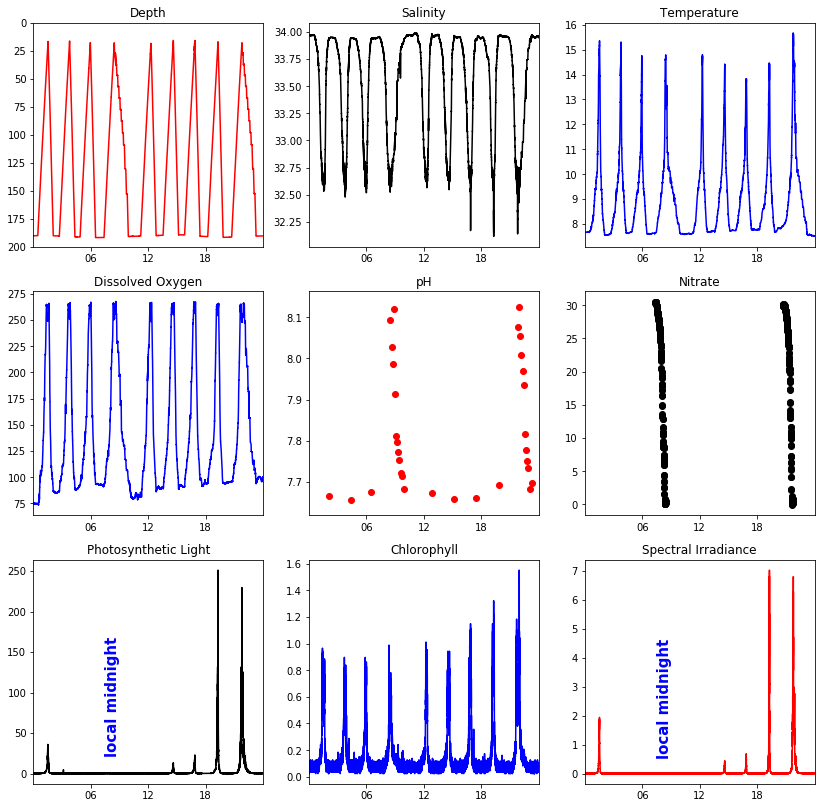

In [4]:
rn = range(9); rsi = range(7)

p,a=plt.subplots(3, 3, figsize=(14,14))
plt.rcParams.update({'font.size': 10})
a[0,0].plot(ctdF.time, ctdF.depth, color='r');                                  a[0,0].set(ylim=(200.,0.), title='Depth')
a[0,1].plot(ctdF.time, ctdF.salinity, color='k');                               a[0,1].set(title='Salinity')
a[0,2].plot(ctdF.time, ctdF.temperature, color='b');                            a[0,2].set(title='Temperature')
a[1,0].plot(ctdF.time, ctdF.dissolved_oxygen, color='b');                       a[1,0].set(title='Dissolved Oxygen')
a[1,1].scatter(phF.time.values, phF.ph_seawater.values, color='r');             a[1,1].set(title='pH')
a[1,2].scatter(nitrateF.time.values, nitrateF.scn.values, color='k');           a[1,2].set(title='Nitrate')
a[2,0].plot(parF.time, parF.par_counts_output, color='k');                      a[2,0].set(title='Photosynthetic Light')
a[2,1].plot(fluorF.time, fluorF.fluorometric_chlorophyll_a, color='b');         a[2,1].set(title='Chlorophyll')
a[2,2].plot(siF.time, siF.si0, color='r');                                      a[2,2].set(title='Spectral Irradiance')

a[2,0].text(dt64('2017-08-21T07:30'), 155., 'local midnight', rotation=90, fontsize=15, color='blue', fontweight='bold')
a[2,2].text(dt64('2017-08-21T07:30'), 4.25, 'local midnight', rotation=90, fontsize=15, color='blue', fontweight='bold')

tFmt   = mdates.DateFormatter("%H")                 # an extended format for strftime() is "%d/%m/%y %H:%M"
t0, t1 = ctdF.time[0].values, ctdF.time[-1].values  # establish same time range for each chart
tticks = [dt64('2017-08-21T06:00'), dt64('2017-08-21T12:00'), dt64('2017-08-21T18:00')]

for i in rn: j, k = i//3, i%3; a[j, k].set(xlim=(t0, t1),xticks=tticks); a[j, k].xaxis.set_major_formatter(tFmt)
print('')   

In [8]:
print(type(fluorF.time[0].values))

<class 'numpy.datetime64'>


### Our story so far

Over one day, August 21 2017, we show nine measurements showing the variable nature of the
upper 200 meters of the ocean. The picture is further by changes over the course of the day,
beginning with available light. Further observations:

- depth profiles 4 and 9 were extended; with pauses along the descent
- profiles 7, 8 and 9 show less salty water near the surface
- the water is consistently 8 degrees Celsius warmer at the surface than at 200 meters depth
  - this suggests comparisons to both glodap and argo 
- there is more dissolved oxygen at the surface
- the surface water is more alkaline
- the surface water has more nitrate
- the time axis is in UTC (Greenwich) time, about 7 hours ahead of local time
- chlorophyll increases over the daylight hours
- it is always dark at 200 meters depth regardless of time of day

Next let's consider how depth directly associates with temperature, chlorophyll and so on. We replace the time 
axis with the other parameters and keep depth on the y-axis with the ocean surface at the top. When possible we
will indicate data from all nine profiles using a different color for each. We use slider-selectors to emphasize
particular profiles.

In [34]:
# These are the time ranges for each of the nine profiles
profdt = [
    (dt64('2017-08-21T00:27:30'),dt64('2017-08-21T02:05:00')),
    (dt64('2017-08-21T02:42:30'),dt64('2017-08-21T04:19:50')),
    (dt64('2017-08-21T04:52:30'),dt64('2017-08-21T06:29:50')),
    (dt64('2017-08-21T07:22:30'),dt64('2017-08-21T09:55:40')),
    (dt64('2017-08-21T11:12:40'),dt64('2017-08-21T12:49:50')),
    (dt64('2017-08-21T13:32:35'),dt64('2017-08-21T15:09:42')),
    (dt64('2017-08-21T15:47:30'),dt64('2017-08-21T17:25:00')),
    (dt64('2017-08-21T18:12:30'),dt64('2017-08-21T19:49:50')),
    (dt64('2017-08-21T20:42:30'),dt64('2017-08-21T23:16:00'))
]



In [35]:
depth=ctdF.depth.to_dataset(name='depth')              # pulls out the depth as a DataArray > Dataset
depth.depth.attrs['low_value'] = 200.
depth.depth.attrs['high_value'] = 0.

salinity=ctdF.salinity.to_dataset(name='salinity')
salinity.salinity.attrs['low_value'] = 32.
salinity.salinity.attrs['high_value'] = 34.

temperature=ctdF.temperature.to_dataset(name='temperature')
temperature.temperature.attrs['low_value'] = 7.
temperature.temperature.attrs['high_value'] = 16.

DO=ctdF.dissolved_oxygen.to_dataset(name='DO')
DO.DO.attrs['low_value'] = 70.
DO.DO.attrs['high_value'] = 280.
DO

<xarray.Dataset>
Dimensions:  (time: 86397)
Coordinates:
  * time     (time) datetime64[ns] 2017-08-21T00:00:00.803386736 ... 2017-08-21T23:59:59.015734640
Data variables:
    DO       (time) float64 75.05 75.02 75.04 75.04 ... 100.5 100.5 100.5 100.4

In [52]:
# The Datasets built above are from single DataArrays where the principle coordinate/dimension 
#   has been modified to be time (from observation index 'obs'). These Data variables are 
#   synchronized with depth as they are all produced by the same instrument (the CTD). 
# In what follows the remaining measurements ( pH, nitrate, par, fluor, si ) will require
#   their own depth Data variables; synchronized in time. These values are provided in the
#   source data files via interpolation but I discarded them for the sake of learning how to
#   do this myself. It is generally not the case that this is 'already done for you' as it 
#   is in this instance.
# Some of the subsequent Datasets are further extended by pulling (salinity, temp, DO) values
#   from the CTD. 

pH=phF.ph_seawater.to_dataset(name='pH')
pH.coords['time'] = ('time', pH.time)
pH['pH'] = (('time'), pH.pH)
pH.pH.attrs['low_value'] = 7.6
pH.pH.attrs['high_value'] = 8.2
pH=pH.drop('obs').drop('lat').drop('lon').drop('int_ctd_pressure')
pH['depth']=('time', depth.depth.sel(time=pH.time, method='nearest'))
pH['salinity']=('time', salinity.salinity.sel(time=pH.time, method='nearest'))
pH['temperature']=('time', temperature.temperature.sel(time=pH.time, method='nearest'))
pH['DO']=('time', DO.DO.sel(time=pH.time, method='nearest'))
pH['fluor']=('time', fluor.fluor.sel(time=pH.time, method='nearest'))
pH['nitrate']=('time', nitrate.nitrate.sel(time=pH.time, method='nearest'))
pH

<xarray.Dataset>
Dimensions:      (time: 31)
Coordinates:
  * time         (time) datetime64[ns] 2017-08-21T02:05:02.091028480 ... 2017-08-21T23:15:42.545159168
Data variables:
    pH           (time) float64 7.666 7.657 7.676 8.094 ... 7.733 7.684 7.698
    depth        (time) float64 190.3 191.2 192.0 27.56 ... 130.3 152.7 190.6
    salinity     (time) float64 33.94 33.94 33.94 32.66 ... 33.85 33.93 33.97
    temperature  (time) float64 7.566 7.655 7.6 12.63 ... 8.701 8.282 8.06 7.568
    DO           (time) float64 86.82 90.4 93.69 265.0 ... 113.1 106.8 94.59
    fluor        (time) float64 0.0805 0.069 0.092 0.736 ... 0.0575 0.069 0.092
    nitrate      (time) float64 30.41 30.41 30.41 ... 0.6619 0.6619 0.6619

In [60]:
nitrate=nitrateF.salinity_corrected_nitrate.to_dataset(name='nitrate')
nitrate.coords['time'] = ('time', nitrate.time)
nitrate['nitrate'] = (('time'), nitrate.nitrate)
nitrate.nitrate.attrs['low_value'] = 0.
nitrate.nitrate.attrs['high_value'] = 32.
nitrate=nitrate.drop('obs').drop('lat').drop('lon').drop('int_ctd_pressure')
nitrate['depth']=('time', depth.depth.sel(time=nitrate.time, method='nearest'))
nitrate['salinity']=('time', salinity.salinity.sel(time=nitrate.time, method='nearest'))
nitrate['temperature']=('time', temperature.temperature.sel(time=nitrate.time, method='nearest'))
nitrate['DO']=('time', DO.DO.sel(time=nitrate.time, method='nearest'))
nitrate['fluor']=('time', fluor.fluor.sel(time=nitrate.time, method='nearest'))
nitrate['pH']=('time', pH.pH.sel(time=nitrate.time, method='nearest'))

# attribute copies
nitrate.depth.attrs['low_value'] = depth.depth.attrs['low_value']
nitrate.depth.attrs['high_value'] = depth.depth.attrs['high_value']
nitrate.temperature.attrs['low_value'] = temperature.temperature.attrs['low_value']
nitrate.temperature.attrs['high_value'] = temperature.temperature.attrs['high_value']
nitrate.salinity.attrs['low_value'] = salinity.salinity.attrs['low_value']
nitrate.salinity.attrs['high_value'] = salinity.salinity.attrs['high_value']
nitrate.DO.attrs['low_value'] = DO.DO.attrs['low_value']
nitrate.DO.attrs['high_value'] = DO.DO.attrs['high_value']
nitrate.fluor.attrs['low_value'] = fluor.fluor.attrs['low_value']
nitrate.fluor.attrs['high_value'] = fluor.fluor.attrs['high_value']
nitrate.pH.attrs['low_value'] = pH.pH.attrs['low_value']
nitrate.pH.attrs['high_value'] = pH.pH.attrs['high_value']

In [54]:
par=parF.par_counts_output.to_dataset(name='par')
par.coords['time'] = ('time', par.time)
par['par'] = (('time'), par.par)
par=par.drop('obs').drop('lat').drop('lon').drop('int_ctd_pressure')
par['depth']=('time', depth.depth.sel(time=par.time, method='nearest'))
par['salinity']=('time', salinity.salinity.sel(time=par.time, method='nearest'))
par['temperature']=('time', temperature.temperature.sel(time=par.time, method='nearest'))
par['DO']=('time', DO.DO.sel(time=par.time, method='nearest'))
par.par.attrs['low_value'] = 0.
par.par.attrs['high_value'] = 250.
par.depth.attrs['low_value'], par.depth.attrs['high_value'] = depth.depth.attrs['low_value'], depth.depth.attrs['high_value']
par.temperature.attrs['low_value'], par.temperature.attrs['high_value'] = temperature.temperature.attrs['low_value'], temperature.temperature.attrs['high_value']
par.salinity.attrs['low_value'], par.salinity.attrs['high_value'] = salinity.salinity.attrs['low_value'], salinity.salinity.attrs['high_value']
par.DO.attrs['low_value'], par.DO.attrs['high_value'] = DO.DO.attrs['low_value'], DO.DO.attrs['high_value']
par

<xarray.Dataset>
Dimensions:      (time: 304327)
Coordinates:
  * time         (time) datetime64[ns] 2017-08-21T00:00:00.042550272 ... 2017-08-21T23:59:59.890661888
Data variables:
    par          (time) float64 0.091 0.102 0.09587 ... 0.1095 0.1366 0.09972
    depth        (time) float64 190.3 190.3 190.3 190.3 ... 190.5 190.5 190.5
    salinity     (time) float64 33.97 33.97 33.97 33.97 ... 33.95 33.95 33.95
    temperature  (time) float64 7.668 7.668 7.668 7.668 ... 7.523 7.523 7.523
    DO           (time) float64 75.05 75.05 75.05 75.05 ... 100.4 100.4 100.4

In [ ]:
fluor=fluorF.fluorometric_chlorophyll_a.to_dataset(name='fluor')
fluor.coords['time'] = ('time', fluor.time)
fluor['fluor'] = (('time'), fluor.fluor)
fluor.fluor.attrs['low_value'] = 0.0
fluor.fluor.attrs['high_value'] = 1.6
fluor=fluor.drop('obs').drop('lat').drop('lon').drop('int_ctd_pressure')
fluor['depth']=('time', depth.depth.sel(time=fluor.time, method='nearest'))
fluor['salinity']=('time', salinity.salinity.sel(time=fluor.time, method='nearest'))
fluor['temperature']=('time', temperature.temperature.sel(time=fluor.time, method='nearest'))
fluor['DO']=('time', DO.DO.sel(time=fluor.time, method='nearest'))
fluor.depth.attrs['low_value'] = depth.depth.attrs['low_value']
fluor.depth.attrs['high_value'] = depth.depth.attrs['high_value']
fluor.temperature.attrs['low_value'] = temperature.temperature.attrs['low_value']
fluor.temperature.attrs['high_value'] = temperature.temperature.attrs['high_value']
fluor.salinity.attrs['low_value'] = salinity.salinity.attrs['low_value']
fluor.salinity.attrs['high_value'] = salinity.salinity.attrs['high_value']
fluor.DO.attrs['low_value'] = DO.DO.attrs['low_value']
fluor.DO.attrs['high_value'] = DO.DO.attrs['high_value']

In [45]:
si0=siF
si0['depth']=('time', depth.depth.sel(time=si.time, method='nearest'))
si0.si0.attrs['low_value'] = 0.
si0.si0.attrs['high_value'] = 7.
si0['depth']=('time', depth.depth.sel(time=si0.time, method='nearest'))
si0['salinity']=('time', salinity.salinity.sel(time=si0.time, method='nearest'))
si0['temperature']=('time', temperature.temperature.sel(time=si0.time, method='nearest'))
si0['DO']=('time', DO.DO.sel(time=si0.time, method='nearest'))
si0['par']=('time', par.par.sel(time=si0.time, method='nearest'))
si0.depth.attrs['low_value'] = depth.depth.attrs['low_value']
si0.depth.attrs['high_value'] = depth.depth.attrs['high_value']
si0.temperature.attrs['low_value'] = temperature.temperature.attrs['low_value']
si0.temperature.attrs['high_value'] = temperature.temperature.attrs['high_value']
si0.salinity.attrs['low_value'] = salinity.salinity.attrs['low_value']
si0.salinity.attrs['high_value'] = salinity.salinity.attrs['high_value']
si0.DO.attrs['low_value'] = DO.DO.attrs['low_value']
si0.DO.attrs['high_value'] = DO.DO.attrs['high_value']
si0.par.attrs['low_value'] = par.par.attrs['low_value']
si0.par.attrs['high_value'] = par.par.attrs['high_value']
print(si0, '\n\n\n', si0.par.attrs)

<xarray.Dataset>
Dimensions:      (time: 344171)
Coordinates:
  * time         (time) datetime64[ns] 2017-08-21T00:00:00.182560512 ... 2017-08-21T23:59:59.962095360
Data variables:
    si0          (time) float64 0.004049 0.002049 0.003238 ... 0.009581 0.00641
    depth        (time) float64 190.3 190.3 190.3 190.3 ... 190.5 190.5 190.5
    salinity     (time) float64 33.97 33.97 33.97 33.97 ... 33.95 33.95 33.95
    temperature  (time) float64 7.668 7.668 7.668 7.668 ... 7.523 7.523 7.523
    DO           (time) float64 75.05 75.05 75.05 75.05 ... 100.4 100.4 100.4
    par          (time) float64 0.091 0.102 0.09587 ... 0.1095 0.1366 0.09972 


 OrderedDict([('low_value', 0.0), ('high_value', 250.0)])


In [56]:
# strictly depth against some other parameter
colorize = ['red', 'orange', 'yellow', 'green', 'lightgreen', 'cyan', 'blue', 'magenta', 'black']

argo_d = g.SetDataDirectory('ooi/argo')
argo2 = xr.open_dataset(argo_d + 'profile2.nc')
a2psu=argo2.PSAL_ADJUSTED[0].to_dataset(name='psu')
a2psu.coords['depth'] = ('depth', argo2.PRES_ADJUSTED[0])
a2psu['psu'] = (('depth'), a2psu.psu)

def VDC(da, z, profile_index, xlabel):       # Versus-Depth Chart
    fig,axes = plt.subplots()
    fig.set_size_inches(13,9)
    axes.set(xlim=(da.low_value, da.high_value), ylim=(200., 0.), xlabel=xlabel, ylabel='Depth (meters)')
    for i in range(9):
        if i != profile_index: 
            tmp   = da.where(da.time > profdt[i][0], drop = True)
            tmp1  = tmp.where(tmp.time < profdt[i][1], drop = True)
            dtmp  = z.where(z.time >  profdt[i][0], drop = True)
            dtmp1 = dtmp.where(dtmp.time < profdt[i][1], drop = True)
            # print(tmp1, '\n\n\n', dtmp1)
            axes.plot(tmp1, dtmp1, ',', color=colorize[i])   # ',' gives small markers
    # Now the selected profile prints on top with larger markers
    tmp   = da.where(da.time > profdt[profile_index][0], drop = True)
    tmp1  = tmp.where(tmp.time < profdt[profile_index][1], drop = True)
    dtmp  = z.where(z.time >  profdt[profile_index][0], drop = True)
    dtmp1 = dtmp.where(dtmp.time < profdt[profile_index][1], drop = True)       
    axes.plot(tmp1, dtmp1, '.', color = colorize[profile_index])    # '.' larger markers
    axes.plot(a2psu.psu.values, a2psu.depth.values, 'o-', color='black')


def PlotConfigure(X_choice, profile_choice):
    profIdx = profile_choice - 1
    if   X_choice == 'depth'      : VDC(depth.depth, depth.depth, profIdx, 'depth (meters)')
    elif X_choice == 'temperature': VDC(temperature.temperature, depth.depth, profIdx, 'temperature (deg C)')
    elif X_choice == 'salinity'   : VDC(salinity.salinity, depth.depth, profIdx, 'salinity (psu)')
    elif X_choice == 'DO'         : VDC(DO.DO, depth.depth, profIdx, 'dissolved oxygen (ug/l)')
    elif X_choice == 'nitrate'    : VDC(nitrate.nitrate, nitrate.depth, profIdx, 'nitrate')
    elif X_choice == 'pH'         : VDC(pH.pH, pH.depth, profIdx, 'pH')
    elif X_choice == 'PAR'        : VDC(par.par, par.depth, profIdx, 'light (PAR)')
    elif X_choice == 'chlorophyll': VDC(fluor.fluor, fluor.depth, profIdx, 'chlorophyll')
    else                          : VDC(si.si0, si.depth, profIdx, 'spectral irradiance')
        
interact(PlotConfigure, 
         profile_choice=widgets.IntSlider(min = 1, max = 9, step = 1, value = 4, 
                    continuous_update = False, readout_format = 'd', description='profile (1-9)'),       
         X_choice = widgets.Select(options=['depth', 'temperature', 'salinity', 'DO', 
                                               'nitrate', 'pH', 'PAR', 'spectral irradiance', 'chlorophyll'],
                                      value='temperature', description='data type', disabled = False)
        )      

interactive(children=(Select(description='data type', index=1, options=('depth', 'temperature', 'salinity', 'D…

<function __main__.PlotConfigure>

In [ ]:
# fluorF.fluorometric_chlorophyll_a indicates units are micrograms per liter 

In [61]:
def XvY(x, y, xt, yt, xLbl, yLbl, profile):
    fig,axes = plt.subplots()
    fig.set_size_inches(13,9)
    axes.set(xlim=(x.low_value, x.high_value), ylim=(y.low_value, y.high_value), xlabel=xLbl, ylabel=yLbl)
    
    for i in range(9):
        if i != profile: 
            xtmp = x.where(xt > profdt[i][0], drop=True)
            xtmp1 = xtmp.where(xtmp.time < profdt[i][1], drop=True).values
            ytmp  = y.where(yt > profdt[i][0], drop=True)
            ytmp1  = ytmp.where(ytmp.time < profdt[i][1], drop=True).values
            axes.plot(xtmp1, ytmp1, ',', color=colorize[i]) 
    xtmp = x.where(xt > profdt[profile][0], drop=True)
    xtmp1 = xtmp.where(xtmp.time < profdt[profile][1], drop=True).values
    ytmp  = y.where(yt > profdt[profile][0], drop=True)
    ytmp1  = ytmp.where(ytmp.time < profdt[profile][1], drop=True).values
    axes.plot(xtmp1, ytmp1, '^', markersize=3, color=colorize[profile])
        
def Caller(xChoice, yChoice, pChoice):

    # The y-axis owns the chart: The ordinate data must be present in the yChoice Dataset
    if yChoice == 'depth' or yChoice == 'temperature' or yChoice == 'salinity' or yChoice == 'DO':
        
        if   yChoice == 'depth':       y = depth.depth;             yt = depth.time;       ys = 'depth (m)'
        elif yChoice == 'temperature': y = temperature.temperature; yt = temperature.time; ys = 'temp (C)'
        elif yChoice == 'salinity':    y = salinity.salinity;       yt = salinity.time;    ys = 'salinity (psu)'
        elif yChoice == 'DO':          y = DO.DO;                   yt = DO.time;          ys = 'DO (ug/l)'
            
        if   xChoice == 'depth':       x = depth.depth;             xt = depth.time;       xs = 'depth (m)'
        elif xChoice == 'temperature': x = temperature.temperature; xt = temperature.time; xs = 'temp (C)'
        elif xChoice == 'salinity':    x = salinity.salinity;       xt = salinity.time;    xs = 'salinity (psu)'
        elif xChoice == 'DO':          x = DO.DO;                   xt = DO.time;          xs = 'DO (ug/l)'
        else: x, xt, xs = y, yt, ys   # can't handle other options yet

    elif yChoice == 'nitrate':
        
        y  = nitrate.nitrate; yt = nitrate.time; ys = 'nitrate'

        if   xChoice == 'depth':       x = nitrate.depth;       xt = nitrate.time; xs = 'depth (m)'
        elif xChoice == 'temperature': x = nitrate.temperature; xt = nitrate.time; xs = 'temp (C)'
        elif xChoice == 'salinity':    x = nitrate.salinity;    xt = nitrate.time; xs = 'salinity (psu)'
        elif xChoice == 'DO':          x = nitrate.DO;          xt = nitrate.time; xs = 'DO (ug/l)'
        elif xChoice == 'chlor':       x = nitrate.fluor;       xt = nitrate.time; xs = 'chlor'
        elif xChoice == 'pH':          x = nitrate.pH;          xt = nitrate.time; xs = 'pH'
        else: x, xt, xs = y, yt, ys   # can't handle other options yet
        
    elif yChoice == 'PAR':     
        
        y  = par.par; yt = par.time; ys = 'PAR'
        
        if   xChoice == 'depth':       x = par.depth;       xt = par.time; xs = 'depth (m)'
        elif xChoice == 'temperature': x = par.temperature; xt = par.time; xs = 'temp (C)'
        elif xChoice == 'salinity':    x = par.salinity;    xt = par.time; xs = 'salinity (psu)'
        elif xChoice == 'DO':          x = par.DO;          xt = par.time; xs = 'DO (ug/l)'
        else: x, xt, xs = y, yt, ys   # can't handle other options yet
        
    elif yChoice == 'chlor': 
        
        y  = fluor.fluor; yt = fluor.time; ys = 'chlor'
        
        if   xChoice == 'depth':       x = fluor.depth;       xt = fluor.time; xs = 'depth (m)'
        elif xChoice == 'temperature': x = fluor.temperature; xt = fluor.time; xs = 'temp (C)'
        elif xChoice == 'salinity':    x = fluor.salinity;    xt = fluor.time; xs = 'salinity (psu)'
        elif xChoice == 'DO':          x = fluor.DO;          xt = fluor.time; xs = 'DO (ug/l)'
        else: x, xt, xs = y, yt, ys   # can't handle other options yet
    
    elif yChoice == 'si0':
        
        y  = si0.si0; yt = si0.time; ys = 'spectral irradiance channel zero'
        
        if   xChoice == 'depth':       x = si0.depth;       xt = si0.time; xs = 'depth (m)'
        elif xChoice == 'temperature': x = si0.temperature; xt = si0.time; xs = 'temp (C)'
        elif xChoice == 'salinity':    x = si0.salinity;    xt = si0.time; xs = 'salinity (psu)'
        elif xChoice == 'DO':          x = si0.DO;          xt = si0.time; xs = 'DO (ug/l)'
        elif xChoice == 'PAR':         x = si0.par;         xt = si0.time; xs = 'PAR'  
        else: x, xt, xs = y, yt, ys   # can't handle other options yet

    XvY(x, y, xt, yt, xs, ys, pChoice - 1)

interact(Caller, 
         xChoice = widgets.Select(options=['depth', 'temperature', 'salinity', 'DO', 'chlor', 'pH', 'PAR'],
                                  value='salinity', description='X axis', disabled = False),
         yChoice = widgets.Select(options=['depth', 'temperature', 'salinity', 'DO', \
                                           'nitrate', 'PAR', 'chlor', 'si0', 'pH'],
                                  value='temperature', description='Y axis', disabled = False),
         pChoice = widgets.IntSlider(min = 1, max = 9, step = 1, value = 4, 
                                     continuous_update = False, readout_format = 'd', 
                                     description='profile (1-9)'),       
    )

interactive(children=(Select(description='X axis', index=2, options=('depth', 'temperature', 'salinity', 'DO',…

<function __main__.Caller>

The following line magic harmonizes 3D figures with the Jupyter notebook.

In [64]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

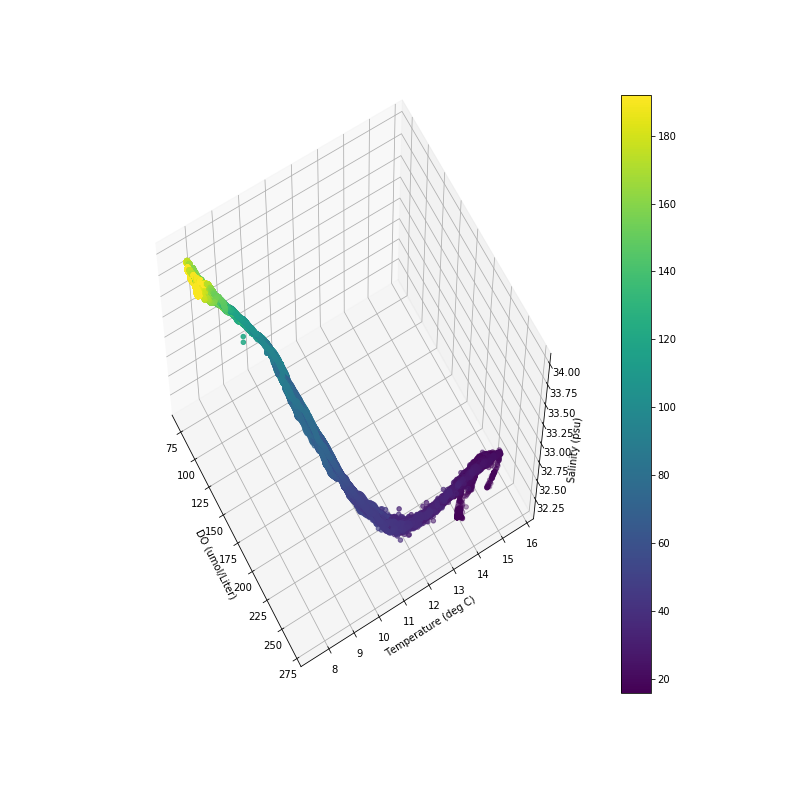

In [72]:
# fig = plt.figure(figsize=plt.figaspect(1.0))
fig = plt.figure(figsize=(11,11))
axes = fig.gca(projection='3d')      # ...or axes = fig.add_subplot(111, projection='3d')
scatter = axes.scatter(DO.DO, temperature.temperature, salinity.salinity, c=depth.depth)
axes.view_init(60, -30)             # 30, -60 (and dist = 10) are the defaults (use axes.azim, .elev, .dist)
axes.set_xlabel("DO (umol/Liter)")
axes.set_ylabel("Temperature (deg C)")
axes.set_zlabel("Salinity (psu)")
fig.colorbar(scatter)
# fig.show()
fig.savefig('fig.png', dpi=200, facecolor='w', edgecolor='w',
        orientation='portrait', pad_inches=0.1,
        frameon=None, metadata=None)

Here it is back.

<img src="./fig.png" style="float: left;" alt="drawing" width="700"/>
<div style="clear: left"><BR>

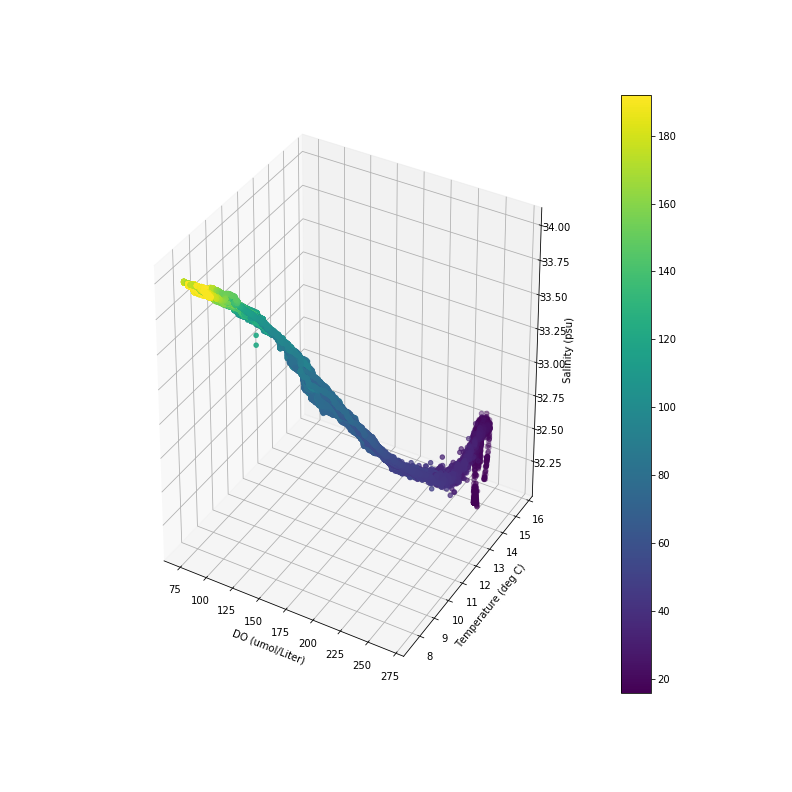

In [69]:
# fig = plt.figure(figsize=plt.figaspect(1.0))
fig = plt.figure(figsize=(11,11))
axes = fig.gca(projection='3d')      # ...or axes = fig.add_subplot(111, projection='3d')
scatter = axes.scatter(DO.DO, temperature.temperature, salinity.salinity, c=depth.depth)
axes.view_init(30, -60)             # 30, -60 (and dist = 10) are the defaults (use axes.azim, .elev, .dist)
axes.set_xlabel("DO (umol/Liter)")
axes.set_ylabel("Temperature (deg C)")
axes.set_zlabel("Salinity (psu)")
fig.colorbar(scatter)
fig.show()

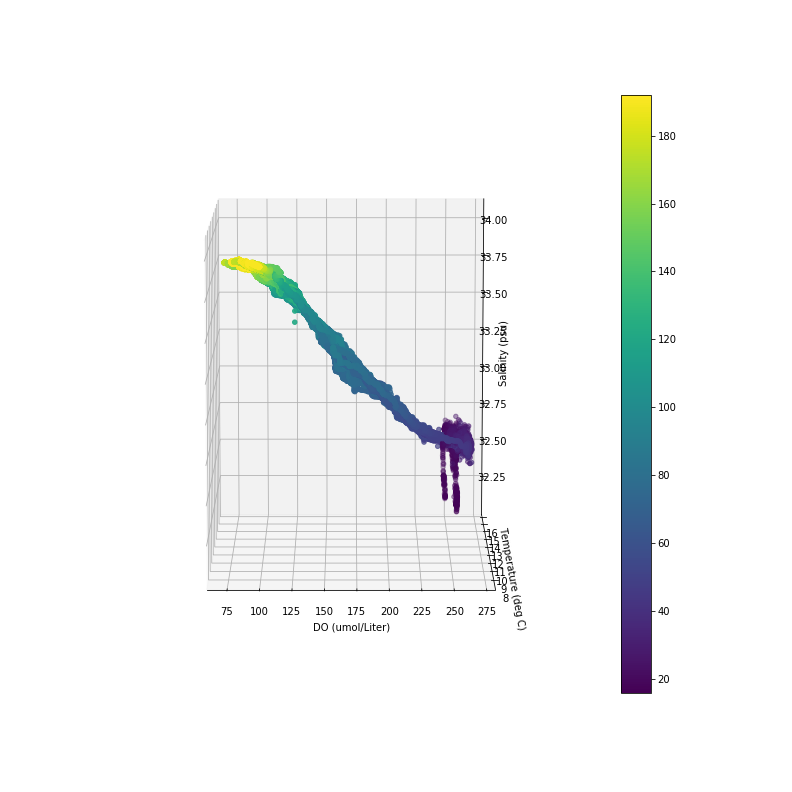

In [70]:
# fig = plt.figure(figsize=plt.figaspect(1.0))
fig = plt.figure(figsize=(11,11))
axes = fig.gca(projection='3d')      # ...or axes = fig.add_subplot(111, projection='3d')
scatter = axes.scatter(DO.DO, temperature.temperature, salinity.salinity, c=depth.depth)
axes.view_init(10, -90)             # 30, -60 (and dist = 10) are the defaults (use axes.azim, .elev, .dist)
axes.set_xlabel("DO (umol/Liter)")
axes.set_ylabel("Temperature (deg C)")
axes.set_zlabel("Salinity (psu)")
fig.colorbar(scatter)
fig.show()

In [71]:
# help(axes.view_init)
# g.dirnou(axes)
# axes.azim
print(axes.azim, axes.elev, axes.dist)

-90 10 10


### including ARGO drifter data

In [ ]:
# !wget ftp://ftp.ifremer.fr/ifremer/coriolis/tmp/co0501/DataSelection_20190320_035619_7746409.tgz

In [ ]:
argo1 = xr.open_dataset('data/argo_profile_1.nc')
argo2 = xr.open_dataset('data/argo_profile_2.nc')
argo2

In [ ]:
print(argo1.LATITUDE[0], argo1.LONGITUDE[0])
print(argo2.LATITUDE[0], argo2.LONGITUDE[0], argo2.LATITUDE[1], argo2.LONGITUDE[1])

In [ ]:
print(argo1.JULD)
print(argo2.TEMP_ADJUSTED[0])
print(argo2.PRES_ADJUSTED[0])

In [ ]:
a2psu=argo2.PSAL_ADJUSTED[0].to_dataset(name='psu')
a2psu.coords['depth'] = ('depth', argo2.PRES_ADJUSTED[0])
a2psu['psu'] = (('depth'), a2psu.psu)
a2psu

In [ ]:
argo_d = g.SetDataDirectory('ooi/argo')
argo1 = xr.open_dataset(argo_d + 'profile1.nc')
argo2 = xr.open_dataset(argo_d + 'profile2.nc')
a2psu=argo2.PSAL_ADJUSTED[0].to_dataset(name='psu')
a2psu.coords['depth'] = ('depth', argo2.PRES_ADJUSTED[0])
a2psu['psu'] = (('depth'), a2psu.psu)
f,a = plt.subplots()
f.set_size_inches(14,9)
a.plot(a2psu.psu.values, a2psu.depth.values, '^', color='red')
a.set(ylim=(200.,0.), xlim=(32.,34.))